In [2]:
# get all libraries

import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import time
import warnings
import contextlib

from sklearn import metrics
from sklearn.metrics import make_scorer,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder

from hyperopt import hp, fmin, tpe,Trials
from IPython.display import HTML

In [84]:
# importing various regression algorithms
# Linear Models
from sklearn.linear_model import LinearRegression

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

# XGBoost
from xgboost import XGBRegressor

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor


the dataset has these features:
* Unit Number - The unique identifier for a Engine type
*  Cycle - Elapsed Cycle
*  3 operational Settings
*  21  Sensor Settings

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
# Read the training Dataset
# List of dataset file names
#data_files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']

data_files = ['train_FD001.txt']
# Initialize an empty DataFrame to hold the combined data
combined_train_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'input',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_train_df = pd.concat([combined_train_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_train_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt


In [5]:
combined_train_df.shape

(20631, 27)

In [6]:
# Read the Validation Dataset
# List of dataset file names
#data_files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']

data_files = ['test_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
combined_test_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'input',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_test_df = pd.concat([combined_test_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_test_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,test_FD001.txt
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,test_FD001.txt
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,test_FD001.txt
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,test_FD001.txt
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,test_FD001.txt


In [7]:
combined_test_df.shape

(13096, 27)

In [8]:
# Read the prediction values
# List of dataset file names
#data_files = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

data_files = ['RUL_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
y_final = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
  osp.curdir,'input',file)
    
    y_temp = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=['RUL'])
    y_temp['source_file'] = file
    
    y_final = pd.concat([y_final, y_temp], ignore_index=True)


y_final.head(5)

,RUL,source_file
0,112,RUL_FD001.txt
1,98,RUL_FD001.txt
2,69,RUL_FD001.txt
3,82,RUL_FD001.txt
4,91,RUL_FD001.txt


In [9]:
y_final.shape

(100, 2)

Calculating the Remaining Useful Life (RUL) is a key aspect when working with the NASA Turbo Fan Jet Engine dataset. The dataset usually consists of multiple engines, each identified by a unit number, and for each engine, we have multiple cycles. The last cycle for each engine usually signifies failure. The idea is to calculate the RUL for each cycle as a countdown to this last cycle.

In [10]:
# create a function to calculate RUL

def calculate_RUL(df):
    # Sort the DataFrame by 'unit_number' and 'time_in_cycles'
    df = df.sort_values(['unit_number', 'time_cycles'])
    
    # Calculate max cycle for each unit
    max_cycle_df  = df.groupby('unit_number')['time_cycles'].max().reset_index()
    max_cycle_df.columns = ['unit_number', 'max_cycle']
    
    # Merge the max cycle back into the original dataframe
    df = df.merge(max_cycle_df, on='unit_number', how='left')
    
    # Calculate RUL for each row
    df['RUL'] = df['max_cycle'] - df['time_cycles']
    
    # Drop the max_cycle column
    df = df.drop('max_cycle', axis=1)
    return df

In [11]:
#Apply the function on the Train set
train_df= calculate_RUL(combined_train_df)
train_df.head(10)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,train_FD001.txt,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,train_FD001.txt,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,train_FD001.txt,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,train_FD001.txt,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,train_FD001.txt,182


In [12]:
#examine the datatype of the train set
train_df.dtypes

unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
sensor_1       float64
sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_5       float64
sensor_6       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_10      float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_16      float64
sensor_17        int64
sensor_18        int64
sensor_19      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

In [13]:
#Check for missing/null values
print(train_df.isnull().sum())

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
sensor_1       0
sensor_2       0
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10      0
sensor_11      0
sensor_12      0
sensor_13      0
sensor_14      0
sensor_15      0
sensor_16      0
sensor_17      0
sensor_18      0
sensor_19      0
sensor_20      0
sensor_21      0
source_file    0
RUL            0
dtype: int64


In [14]:
#Run some basic stats on the data
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


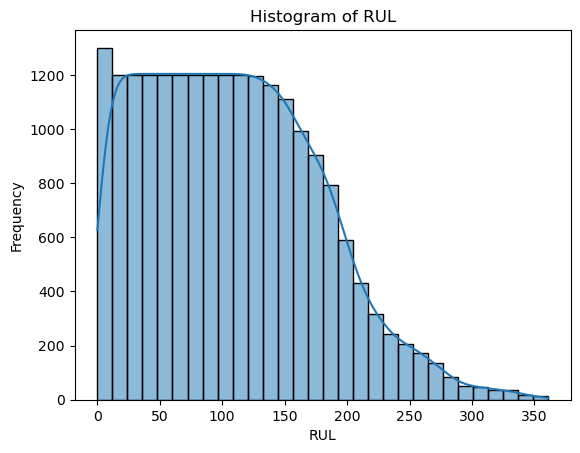

In [15]:
#examine RUL distribution
sns.histplot(train_df["RUL"], bins=30, kde=True)
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.title('Histogram of RUL')
plt.show()

RUL values are mostly concentrated between 0-150 and taper off therafter. 

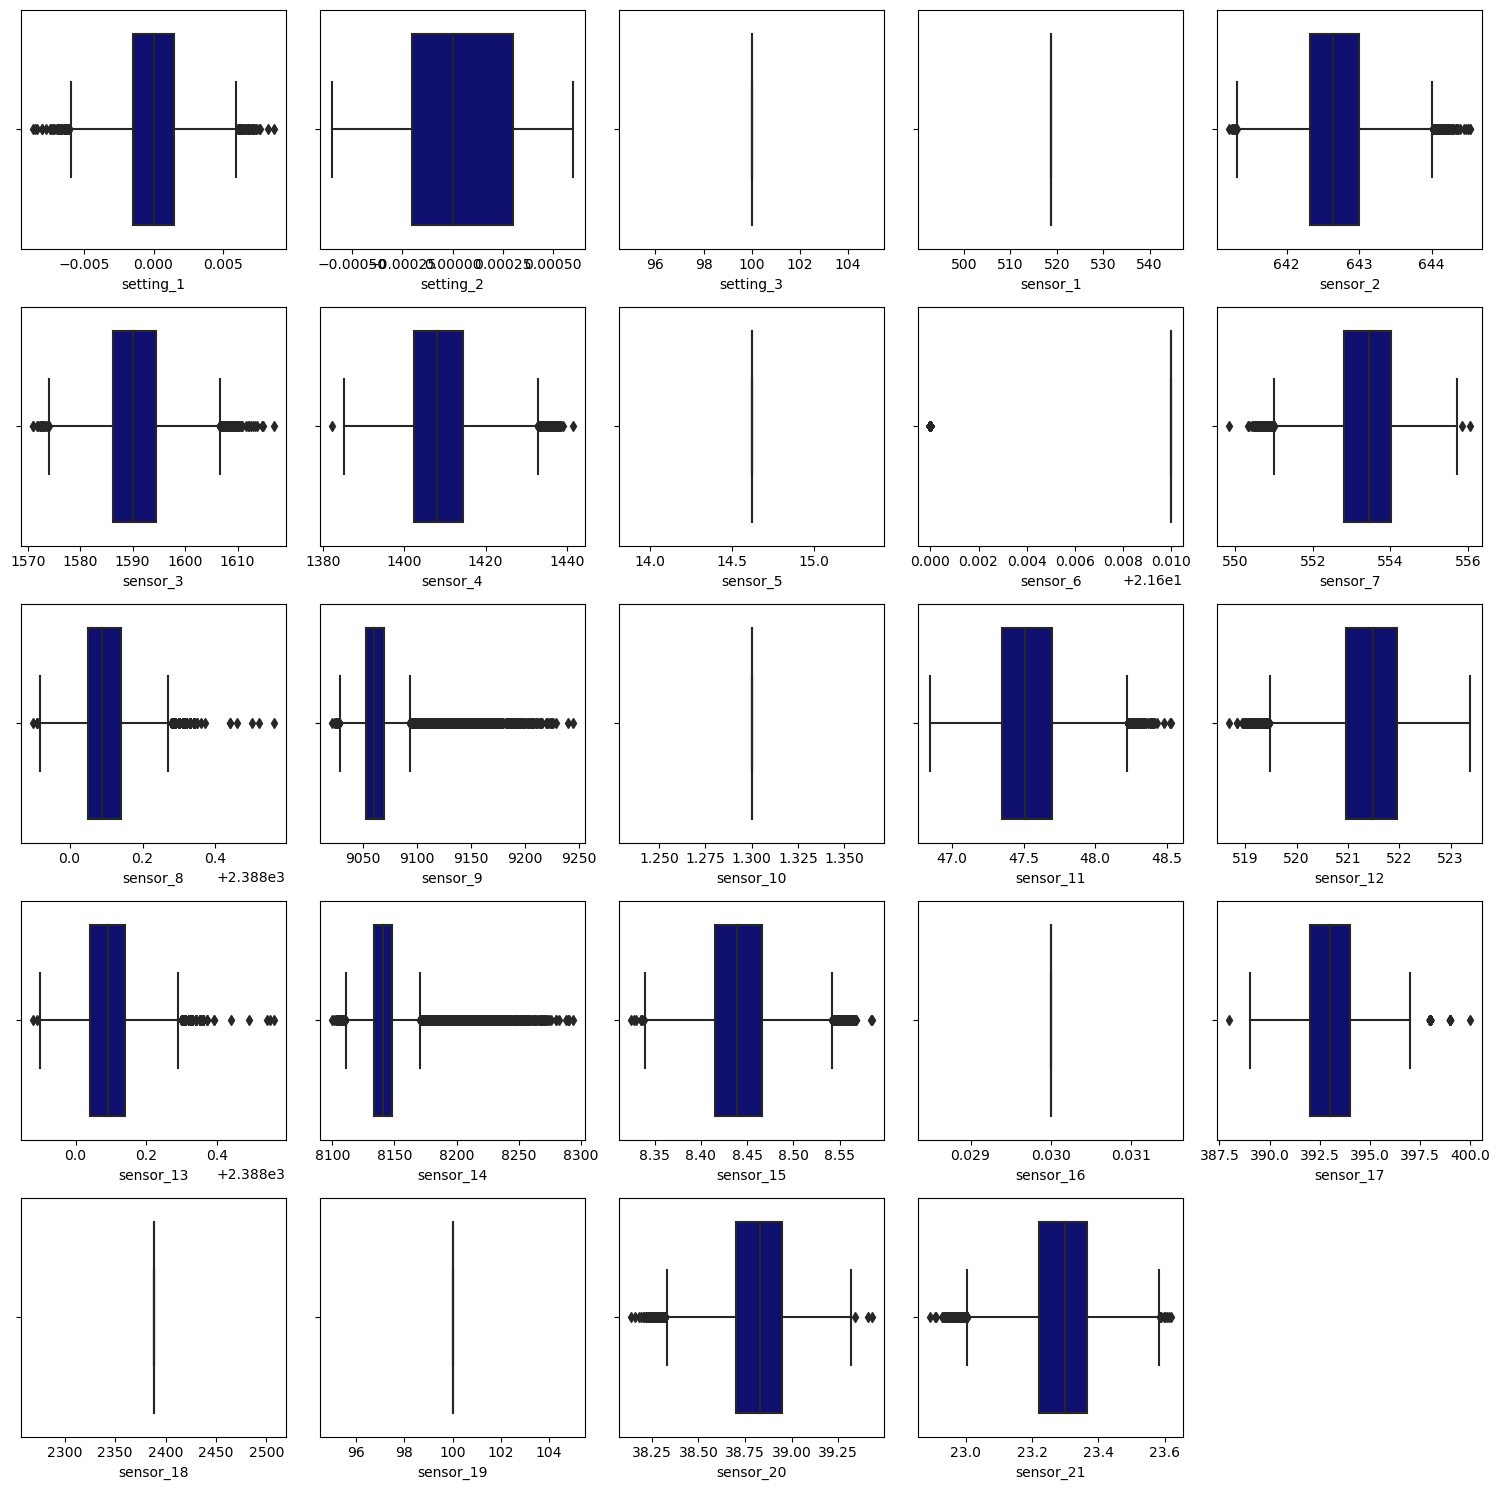

In [16]:
 # EDA for settings and sensors
numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, 
                        figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.boxplot(x=var,data=train_df, ax=axs[i],color="navy")

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


<Axes: >

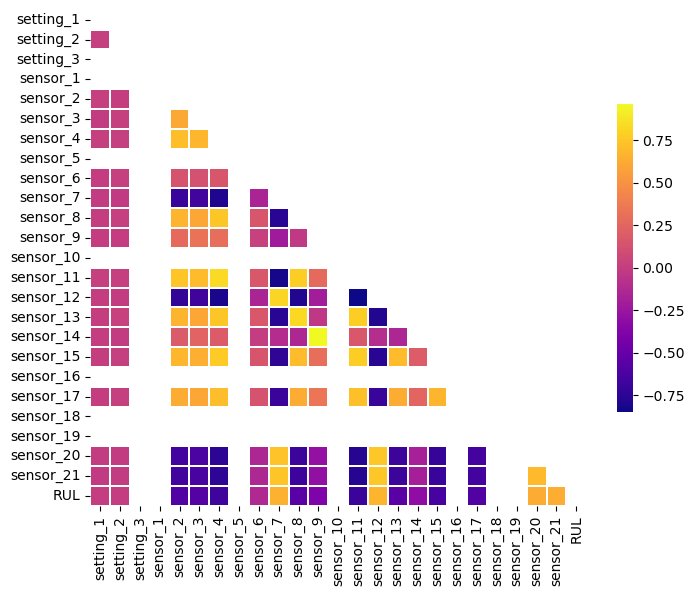

In [17]:
#examine correlations in the train DF
corr_cols = setting_names + sensor_names + ['RUL']
corr = train_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', square=True, linewidths=.01, cbar_kws={"shrink": .5})

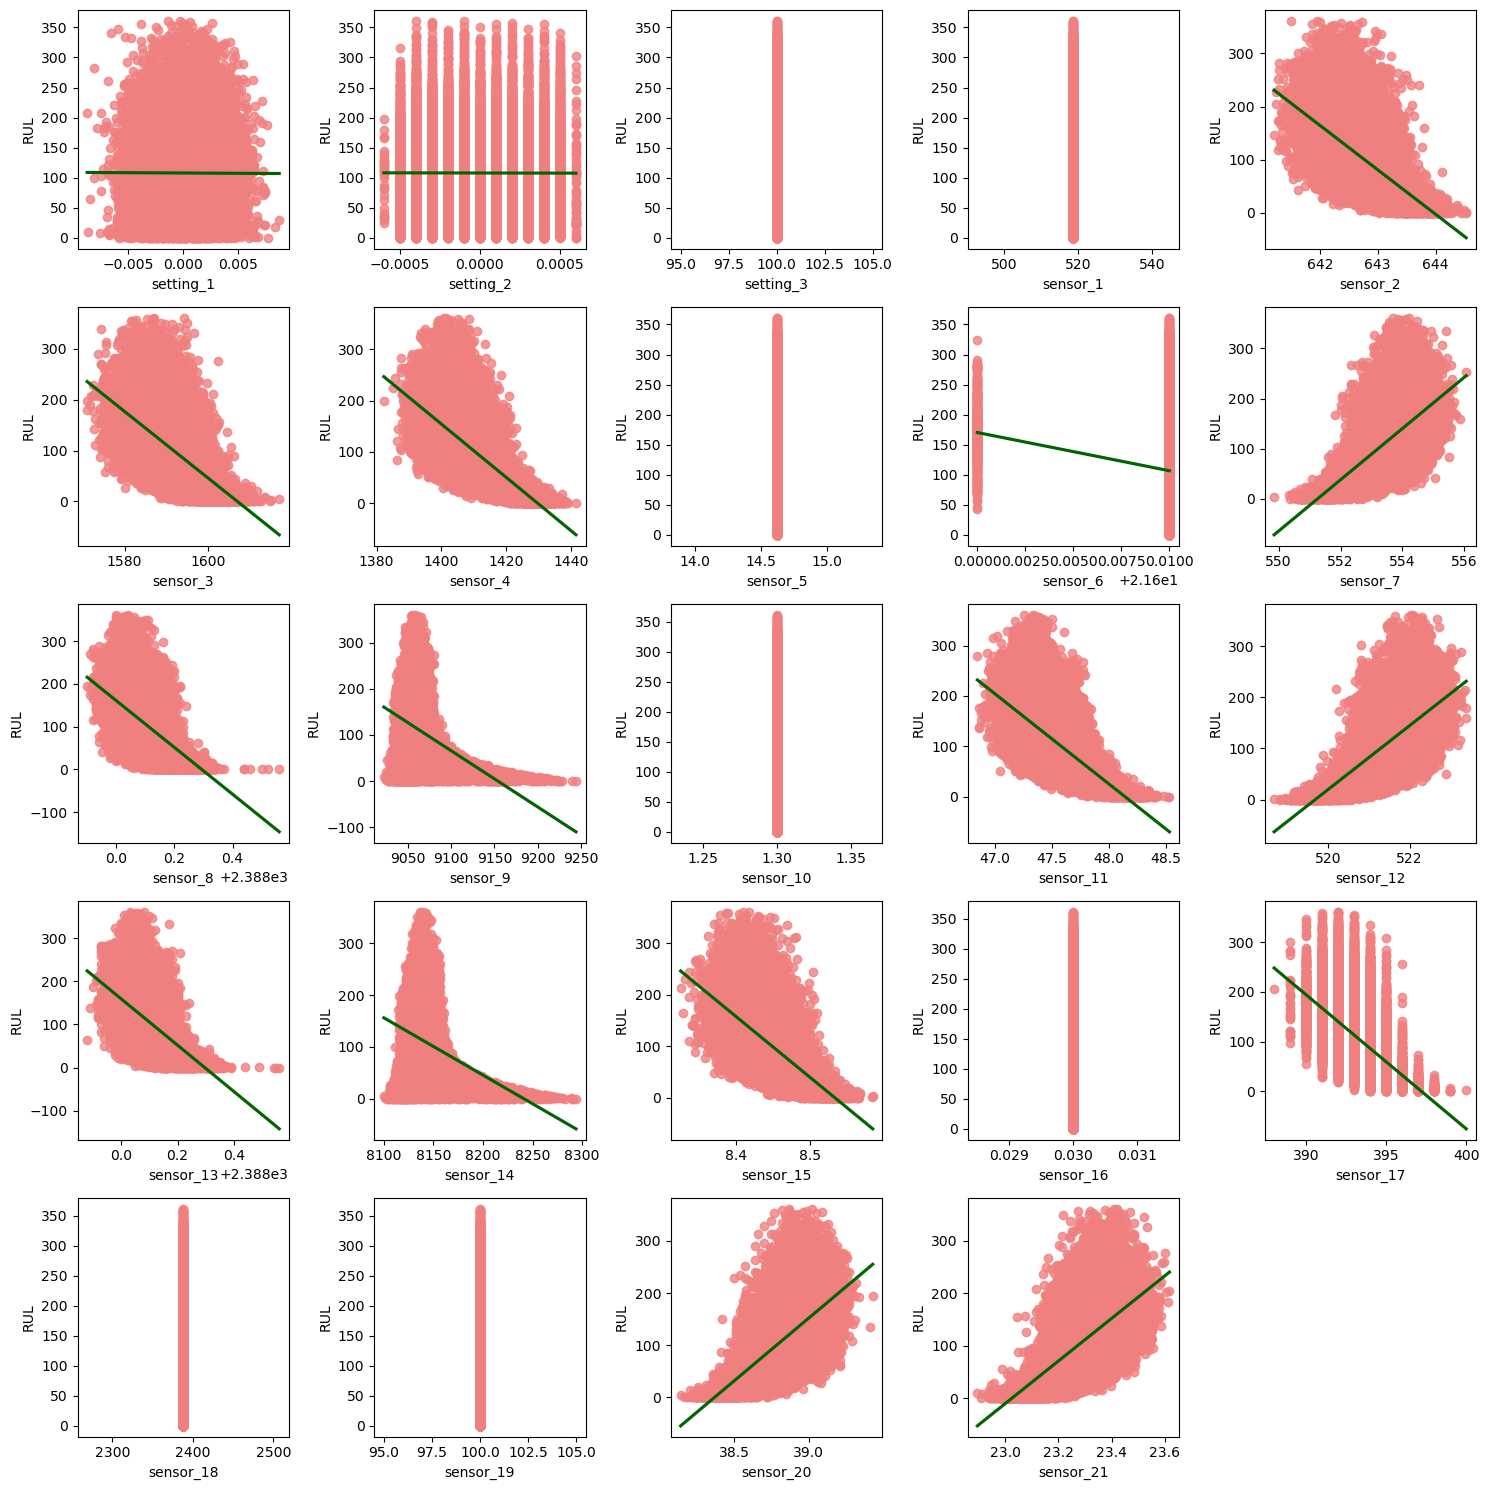

In [18]:
# Do some more EDA w.r.t. to the target

numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.regplot(x=var, y="RUL", data=train_df, ax=axs[i], ci=False, 
                line_kws={'color': 'darkgreen'},scatter_kws={'color': 'lightcoral'})

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


From the above plots, it appears as these sensor values may be constant values or without any correlation with RUL
* setting_1
* setting_2
* setting_3
* sensor_1
* sensor_5
* sensor_6
* sensor_10
* sensor_16
* sensor_18
* sensor_19


We can generate some histograms to confirm if our suspicions are true

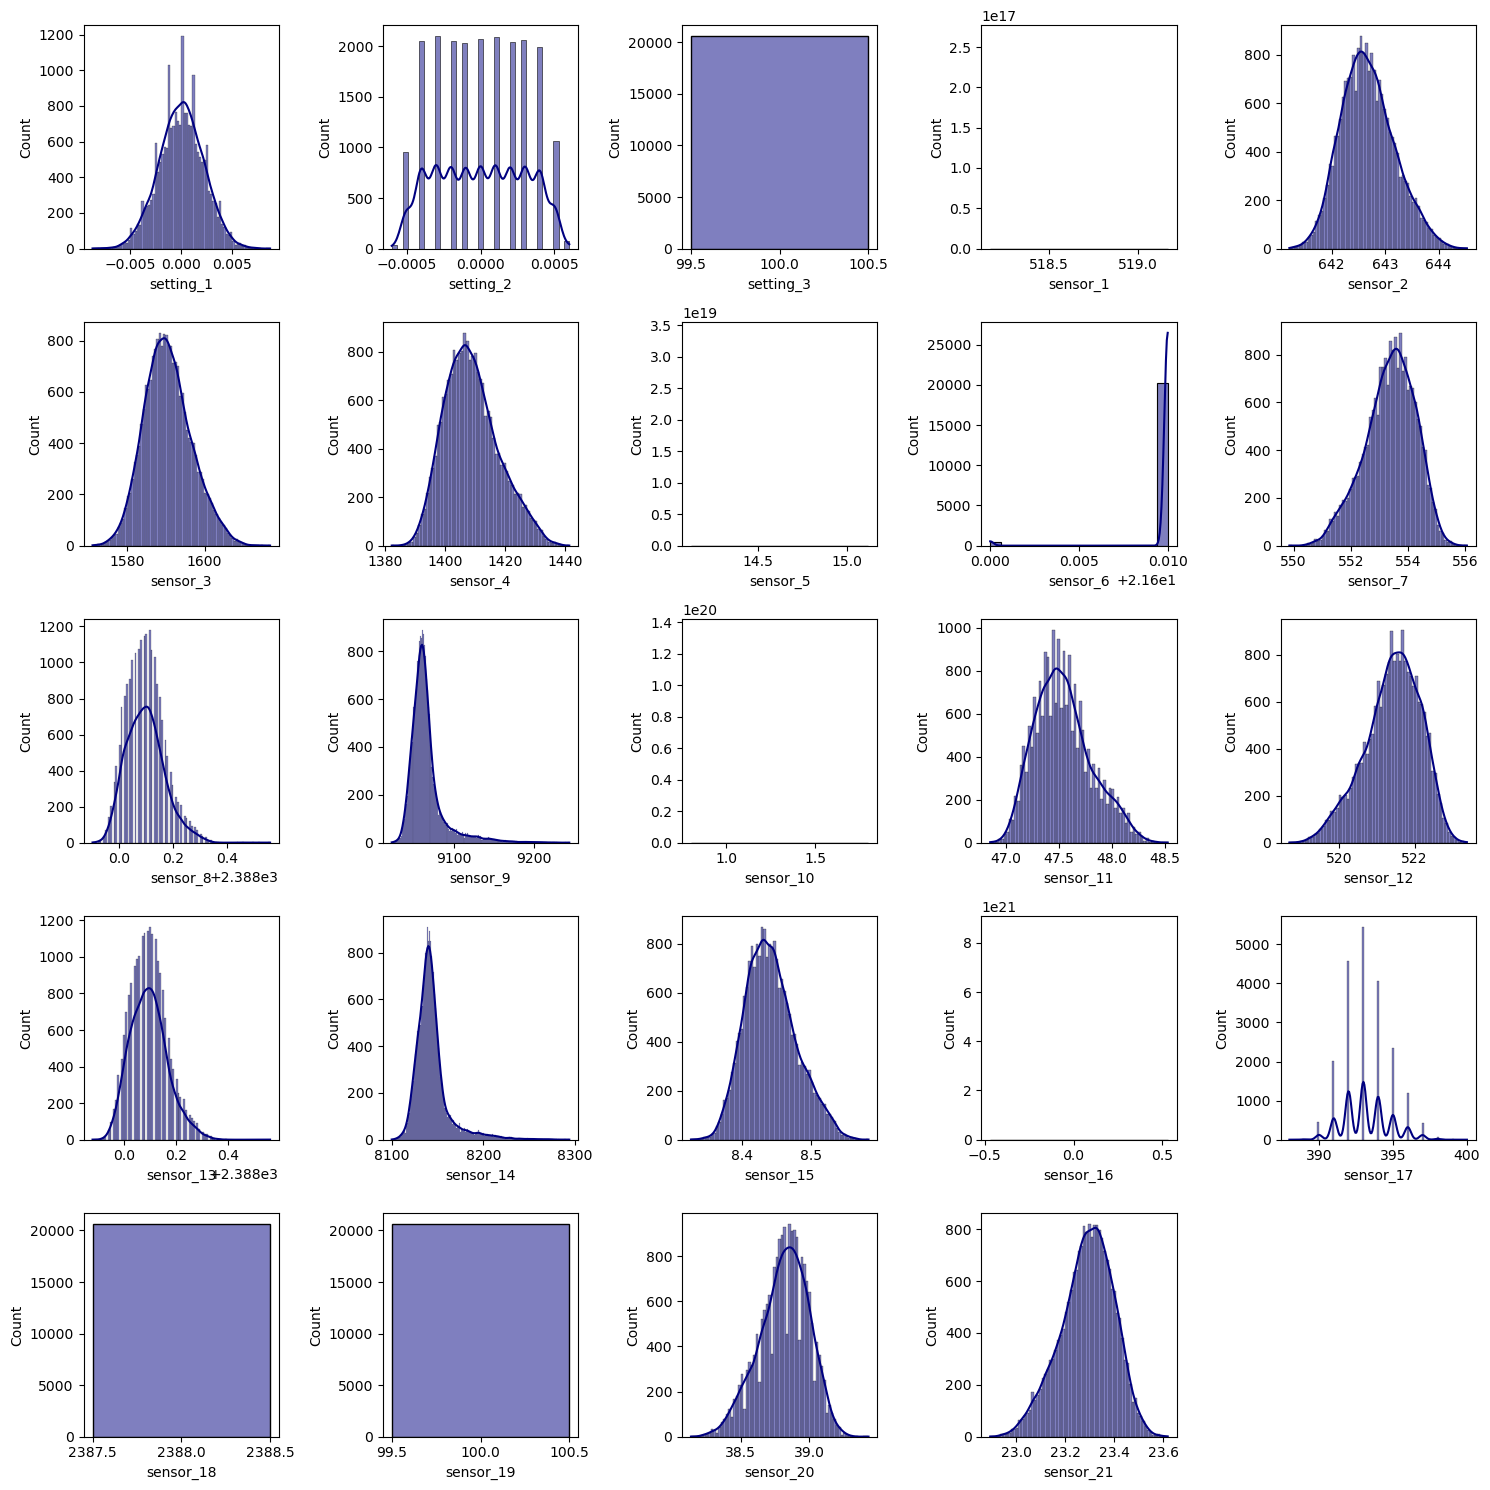

In [19]:
numeric_cols = setting_names + sensor_names

num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3* total_cols, 3 * total_rows))

# Flatten the axs array if total_rows > 1
axs = axs.flatten() if total_rows > 1 else axs

for i, var in enumerate(numeric_cols):
    sns.histplot(data=train_df, x=var, kde=True, color="navy", ax=axs[i])

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


Our suspicions are confirmed and we will drop these features for our model building.We will also drop sensor_17, since there is no obvious relationship between this value and RUL, The distrbution of Sensor 17, also seems to be not ideal for prediction.

Lets proceed now to split our data into train-test sets and comparing various regression models on our data

In [20]:
drop_list = ["setting_1","setting_2","setting_3","sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18","sensor_19","sensor_17"] + index_names
train_df_mod = train_df.drop(columns=drop_list)
train_df_mod.dtypes

sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

from the plots above it appears some of the sensors may have polynomial relationship with RUL. So we will apply a log transform to the RUl and see how the relationships change

In [21]:
train_df_mod['RUL'] = np.log(train_df_mod['RUL']+1)
train_df_mod.dtypes

sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL            float64
dtype: object

Now lets examine the regression plots again

In [22]:
all_columns = train_df_mod.columns.tolist()

# Columns to exclude
exclude_columns = ['source_file', 'RUL']

# Remove the columns you don't want
sensor_columns = [col for col in all_columns if col not in exclude_columns]

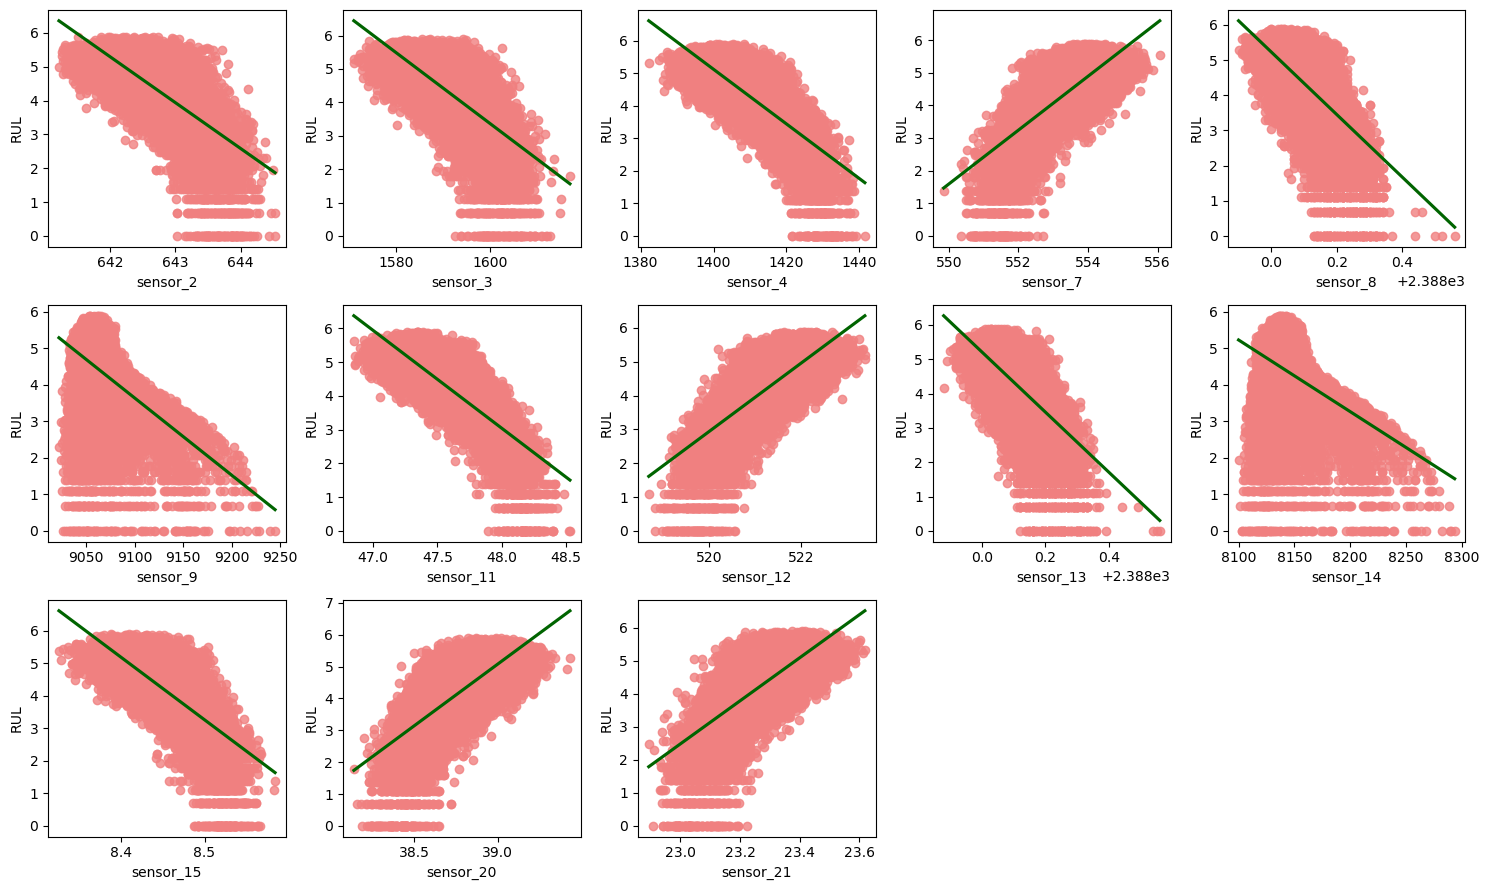

In [23]:
numeric_cols = sensor_columns
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.regplot(x=var, y="RUL", data=train_df_mod, ax=axs[i], ci=False, 
                line_kws={'color': 'darkgreen'},scatter_kws={'color': 'lightcoral'})

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()

looks much better, although the relationships are not Linear

In [24]:
#split training data into train and set split
X  = train_df_mod.drop(columns=["RUL","source_file"])
Y = train_df_mod["RUL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [26]:
print('X_train.shape:',X_train.shape)
print('y_train.shape:',y_train.shape)
print('X_test.shape:',X_test.shape)
print('y_test.shape',y_test.shape)

X_train.shape: (16504, 13)
y_train.shape: (16504,)
X_test.shape: (4127, 13)
y_test.shape (4127,)


### Create a function to evaluate various algorithms with Default Params

In [27]:
# Helper function
def quick_evaluate(X_train, X_test, y_train, y_test, name):
    
       
    lr = LinearRegression()
    dtr = DecisionTreeRegressor(random_state=42)
    rfr = RandomForestRegressor(random_state=42)
    gbr = GradientBoostingRegressor(random_state=42)
    abr = AdaBoostRegressor(random_state=42)
    svr = SVR(kernel='linear')
    knr = KNeighborsRegressor()
    xgr = XGBRegressor(random_state=42)
    lgbmr = LGBMRegressor(random_state=42)
    catr = CatBoostRegressor(random_state=42,verbose=0)
  

      
    regressors = [('LR', lr),('DT', dtr),
                   ('RF', rfr),('GB', gbr),('AB', abr),
                   ('SV', svr),('KN', knr),('XB', xgr),
                  ('LB', lgbmr),('CB', catr)
                 ]
   
    n = len(y_test)
    p = X_test.shape[1]
        
    reg_lst = list()
    for reg_name, reg in regressors:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        R2             = metrics.r2_score(y_test, y_pred)
        ADJ_R2         = 1 - (1-R2)*(n-1)/(n-p-1)
        MAPE           = metrics.mean_absolute_percentage_error(y_test,y_pred)
        MAE            = metrics.mean_absolute_error(y_test,y_pred)
        MSE            = metrics.mean_squared_error(y_test,y_pred)
        RMSE           = np.sqrt(metrics.mean_squared_error(y_test, y_pred))       
        params         = reg.get_params()
        
        df = pd.DataFrame({
                           "Method"    : [name],
                           "Regressor" : [reg_name],
                           "R2"        : [R2],
                           "Adj_R2"    : [ADJ_R2],
                           #"MAPE"      : [MAPE],
                           "MAE"       : [MAE],
                           "MSE"       : [MSE],                           
                           "RMSE"      : [RMSE],                            
                           "Model"     : [params]
                          })
        reg_lst.append(df)
    print(reg_lst)
    dfr = pd.concat([m for m in reg_lst], axis = 0).reset_index()
    dfr = dfr.drop(columns = "index",axis =1)
    return(dfr)

Pass#1 evaluate without scaling

In [28]:
with contextlib.redirect_stdout(None):
    evals = list()
    evals.append(quick_evaluate(X_train, X_test, y_train, y_test,'unscaled'))

Pass#2 evaluate with scaled features

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train_s = sscaler.fit_transform(X_train)
X_test_s =  sscaler.transform(X_test)

X_train_m = mscaler.fit_transform(X_train)
X_test_m =  mscaler.transform(X_test)

In [30]:
with contextlib.redirect_stdout(None):
    #Standard scaling evaluation
    evals.append(quick_evaluate(X_train_s, X_test_s, y_train, y_test,'Standard'))
    
    #Minmax scaling evaluation
    evals.append(quick_evaluate(X_train_m, X_test_m, y_train, y_test,'MinMax'))

In [31]:
#evaluate results
pd.set_option('max_colwidth', 100)
evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['R2','MAE'], ascending=False)

,Method,Regressor,R2,Adj_R2,MAE,MSE,RMSE,Model
9,unscaled,CB,0.850098,0.849624,0.286478,0.136898,0.369997,"{'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}"
19,Standard,CB,0.850077,0.849603,0.286488,0.136916,0.370022,"{'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}"
29,MinMax,CB,0.850077,0.849603,0.286489,0.136916,0.370022,"{'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}"
18,Standard,LB,0.847851,0.847370,0.287909,0.138950,0.372760,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
28,MinMax,LB,0.847775,0.847294,0.287943,0.139019,0.372852,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
8,unscaled,LB,0.847097,0.846614,0.288616,0.139638,0.373682,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
23,MinMax,GB,0.846356,0.845871,0.290833,0.140314,0.374586,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
3,unscaled,GB,0.846324,0.845839,0.290849,0.140344,0.374625,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
13,Standard,GB,0.846322,0.845837,0.290853,0.140345,0.374627,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
22,MinMax,RF,0.844875,0.844384,0.290093,0.141668,0.376388,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."


Catboost algorithm does best but LightGBM is faster to train. So lets use LightGBM and try to do some hyperparameter tuning and see if we can improve the model to be at par or better than Catboost. We will use the Bayesian hyperparameter tuning package Hyperopt to do this.
The models with scaled vs unscaled features don't have much difference in terms of performance. So we will use the model with unscaled features for further tuning

In [55]:
start = time.time()
space_lr = {
    'verbosity': -1,
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),  # Narrowed the range
    'n_estimators': hp.quniform('n_estimators', 270, 290, 10),  # Adjusted values
    'num_leaves': hp.quniform('num_leaves', 20, 25, 1),  # Adjusted values
    'max_depth': hp.quniform('max_depth', 9, 11, 1),  # Adjusted values
    'reg_alpha': hp.uniform('reg_alpha', 0.2, 0.3),  # Adjusted range
    'reg_lambda': hp.uniform('reg_lambda', 0.9, 1.0),  # Narrowed the range
    'subsample': hp.uniform('subsample', 0.85, 0.87),  # Adjusted range
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 0.81),  # Adjusted range
}

def rf_bo(params):
    params['n_estimators'] = int(params['n_estimators'])  # Convert to int
    params['num_leaves'] = int(params['num_leaves'])  # Convert to int
    params['max_depth'] = int(params['max_depth'])  # Convert to int
    #del params['n_estimators']  # Remove the old parameter name
    
    rf = LGBMRegressor(random_state=42, **params, n_jobs=-1)
    
    best_score = cross_val_score(rf, X_train, y_train, 
                                 scoring='neg_root_mean_squared_error', 
                                 cv=10).mean()
    return -best_score

best_model = fmin(fn=rf_bo,
                space=space_lr,
                max_evals=1000,
                rstate=np.random.default_rng(42),
                algo=tpe.suggest)

print('It takes %s minutes' % ((time.time() - start)/60))

best_model

100%|████████████████████████████████████████████| 1000/1000 [32:06<00:00,  1.93s/trial, best loss: 0.3677442280499267]
It takes 32.10250257651011 minutes


{'colsample_bytree': 0.8044646133959511,
 'learning_rate': 0.03273398716817008,
 'max_depth': 11.0,
 'n_estimators': 280.0,
 'num_leaves': 23.0,
 'reg_alpha': 0.2555910760781986,
 'reg_lambda': 0.9529842120808619,
 'subsample': 0.8658772513570173}

In [69]:
bestparameters= {'colsample_bytree': 0.8040055033878275,
 'learning_rate': 0.0353040861986723,
 'max_depth': 10,
 'n_estimators': 280,
 'num_leaves': 22,
 'reg_alpha': 0.23290724595524898,
 'reg_lambda': 0.9627452999044842,
 'subsample': 0.8567847402591068}

'''
Tuned Param 1:'colsample_bytree': 0.7170232943637004,
 'learning_rate': 0.08732056408527754,
 'max_depth': 12,
 'n_estimators': 152,
 'num_leaves': 17,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'subsample': 0.8500801034684838

Tuned Score 1: R2 Score: 0.849058385960618, RMSE: 0.3712773225581628

Tuned Param 2: 'colsample_bytree': 0.7161554787325937,
 'learning_rate': 0.04235297393954099,
 'max_depth': 7,
 'n_estimators': 192,
 'num_leaves': 27,
 'reg_alpha': 0.13841309583328482,
 'reg_lambda': 0.7780975512568702,
 'subsample': 0.9167535828479257

Tuned Score 2: R2 Score: 0.8497116847650865, RMSE: 0.37047297825591513

Tuned Param 3:'colsample_bytree': 0.8040055033878275,
 'learning_rate': 0.0353040861986723,
 'max_depth': 10,
 'n_estimators': 280,
 'num_leaves': 22,
 'reg_alpha': 0.23290724595524898,
 'reg_lambda': 0.9627452999044842,
 'subsample': 0.8567847402591068

Tuned Score 3: R2 Score: 0.8488043643486578, RMSE: 0.3715896049528995

Tuned Param 4:'colsample_bytree': 0.8044646133959511,
 'learning_rate': 0.03273398716817008,
 'max_depth': 11,
 'n_estimators': 280,
 'num_leaves': 23,
 'reg_alpha': 0.2555910760781986,
 'reg_lambda': 0.9529842120808619,
 'subsample': 0.8658772513570173
 
 Tuned Score 4:R2 Score: 0.8495176459729387,RMSE: 0.3707120618495007


'''

best_estimator_hp = LGBMRegressor(random_state=42,**bestparameters)

best_estimator_hp.fit(X_train, y_train)

y_pred_rf = best_estimator_hp.predict(X_test)
# Evaluation
print("R2 Score:", metrics.r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 13
[LightGBM] [Info] Start training from score 4.364404
R2 Score: 0.8488043643486578
RMSE: 0.3715896049528995


We improved our LGBM model and got quite close to the Catboost model's score. We fill this is a good model to be used for predictions

As you can see from the comments, This is not necessarily the best score that we can get on the training dataset, but this set of parameters performs better on the prediction set so we will go with this. 

### Lets now work on the Test(Prediction set)

In [70]:
#We will drop the same columns on the prediction set as we did with the train set
drop_list = ["setting_1","setting_2","setting_3","sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_17","sensor_18","sensor_19", "source_file"] + index_names

X_valid = combined_test_df.groupby('unit_number').last().reset_index().drop(columns=drop_list)

X_valid.dtypes

sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_11    float64
sensor_12    float64
sensor_13    float64
sensor_14    float64
sensor_15    float64
sensor_20    float64
sensor_21    float64
dtype: object

In [71]:
X_valid.head(5)

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_20,sensor_21
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,38.75,23.4117


In [72]:
X_valid.shape

(100, 13)

In [73]:
y_valid = y_final.drop(columns="source_file")
y_valid.shape

(100, 1)

In [74]:
#lets try our  estimator on the prediction set
y_final_pred_hp = best_estimator_hp.predict(X_valid)
y_pred = np.exp(y_final_pred_hp) - 1

In [75]:
# Evaluation
print ("Hyperopt Performance")
print("R2 Score:", metrics.r2_score(y_valid, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

Hyperopt Performance
R2 Score: 0.5618101968952101
RMSE: 27.50811971058086


So, from above results our model is 56.18% accurate on our final predictions and has a RMSE of 27.5

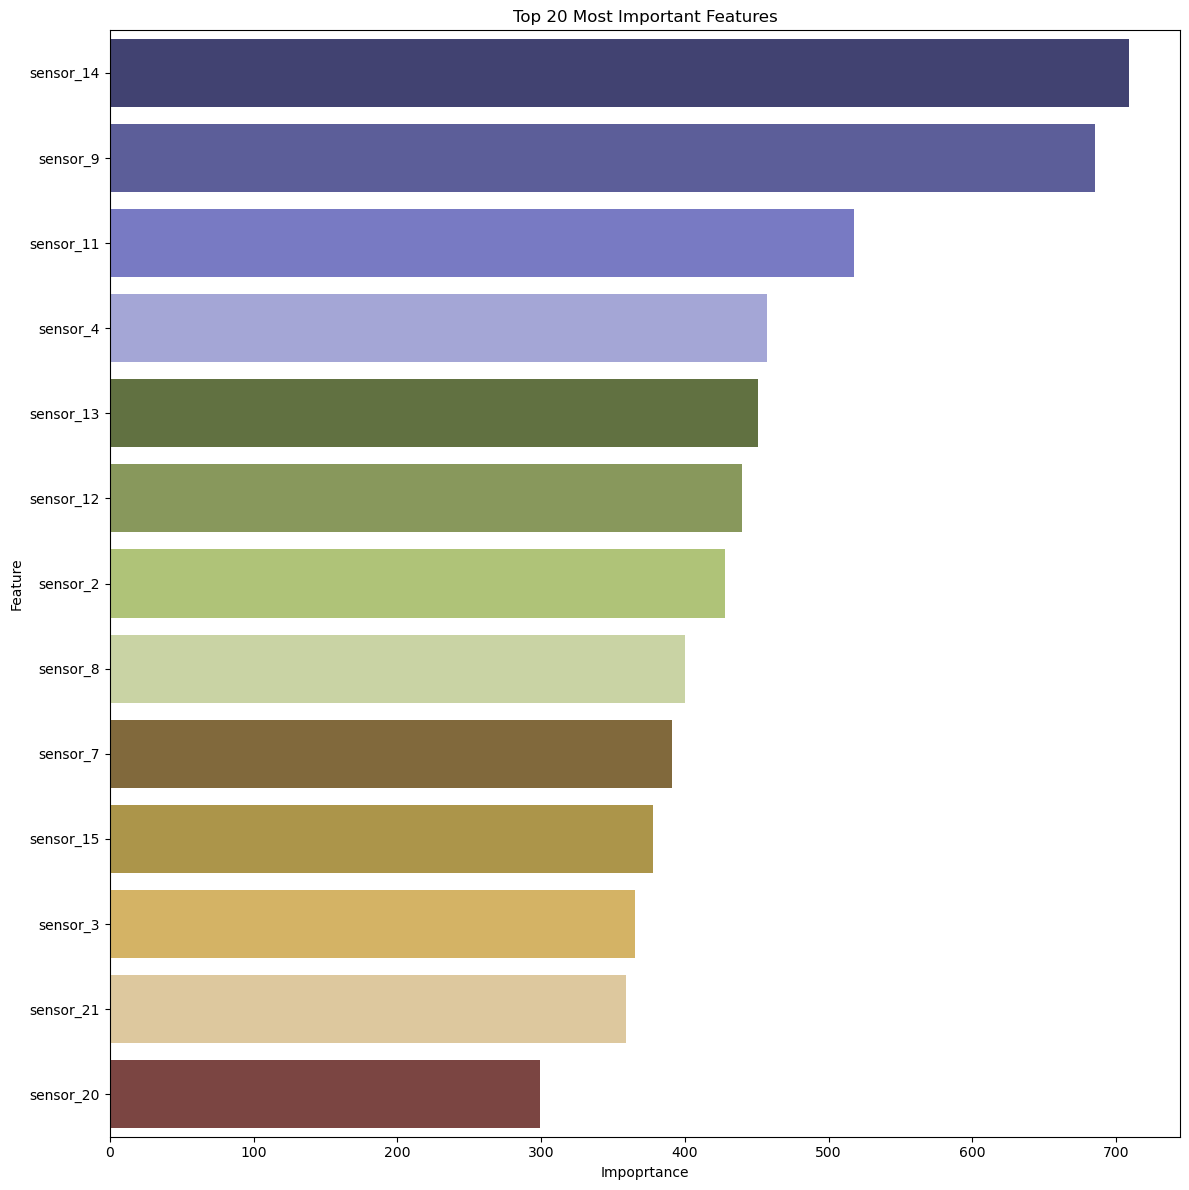

In [76]:
# lets do a feature importance plot to understand which features are most important to the model

# Get feature importances and feature names
feature_importances = best_estimator_hp.feature_importances_
feature_names = X_train.columns

feature_imp = pd.DataFrame(sorted(zip(feature_importances, feature_names)), 
                           columns=['Impoprtance','Feature']).sort_values(by="Impoprtance", ascending=False)

# Select top n features
top_n = 20
top_n_features = feature_imp.head(top_n)

# Generate a diverging color palette
diverging_colors = sns.color_palette("tab20b", n_colors=len(top_n_features))

plt.figure(figsize=(12, 12))
sns.barplot(x="Impoprtance", y="Feature", data=top_n_features,palette=diverging_colors)
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

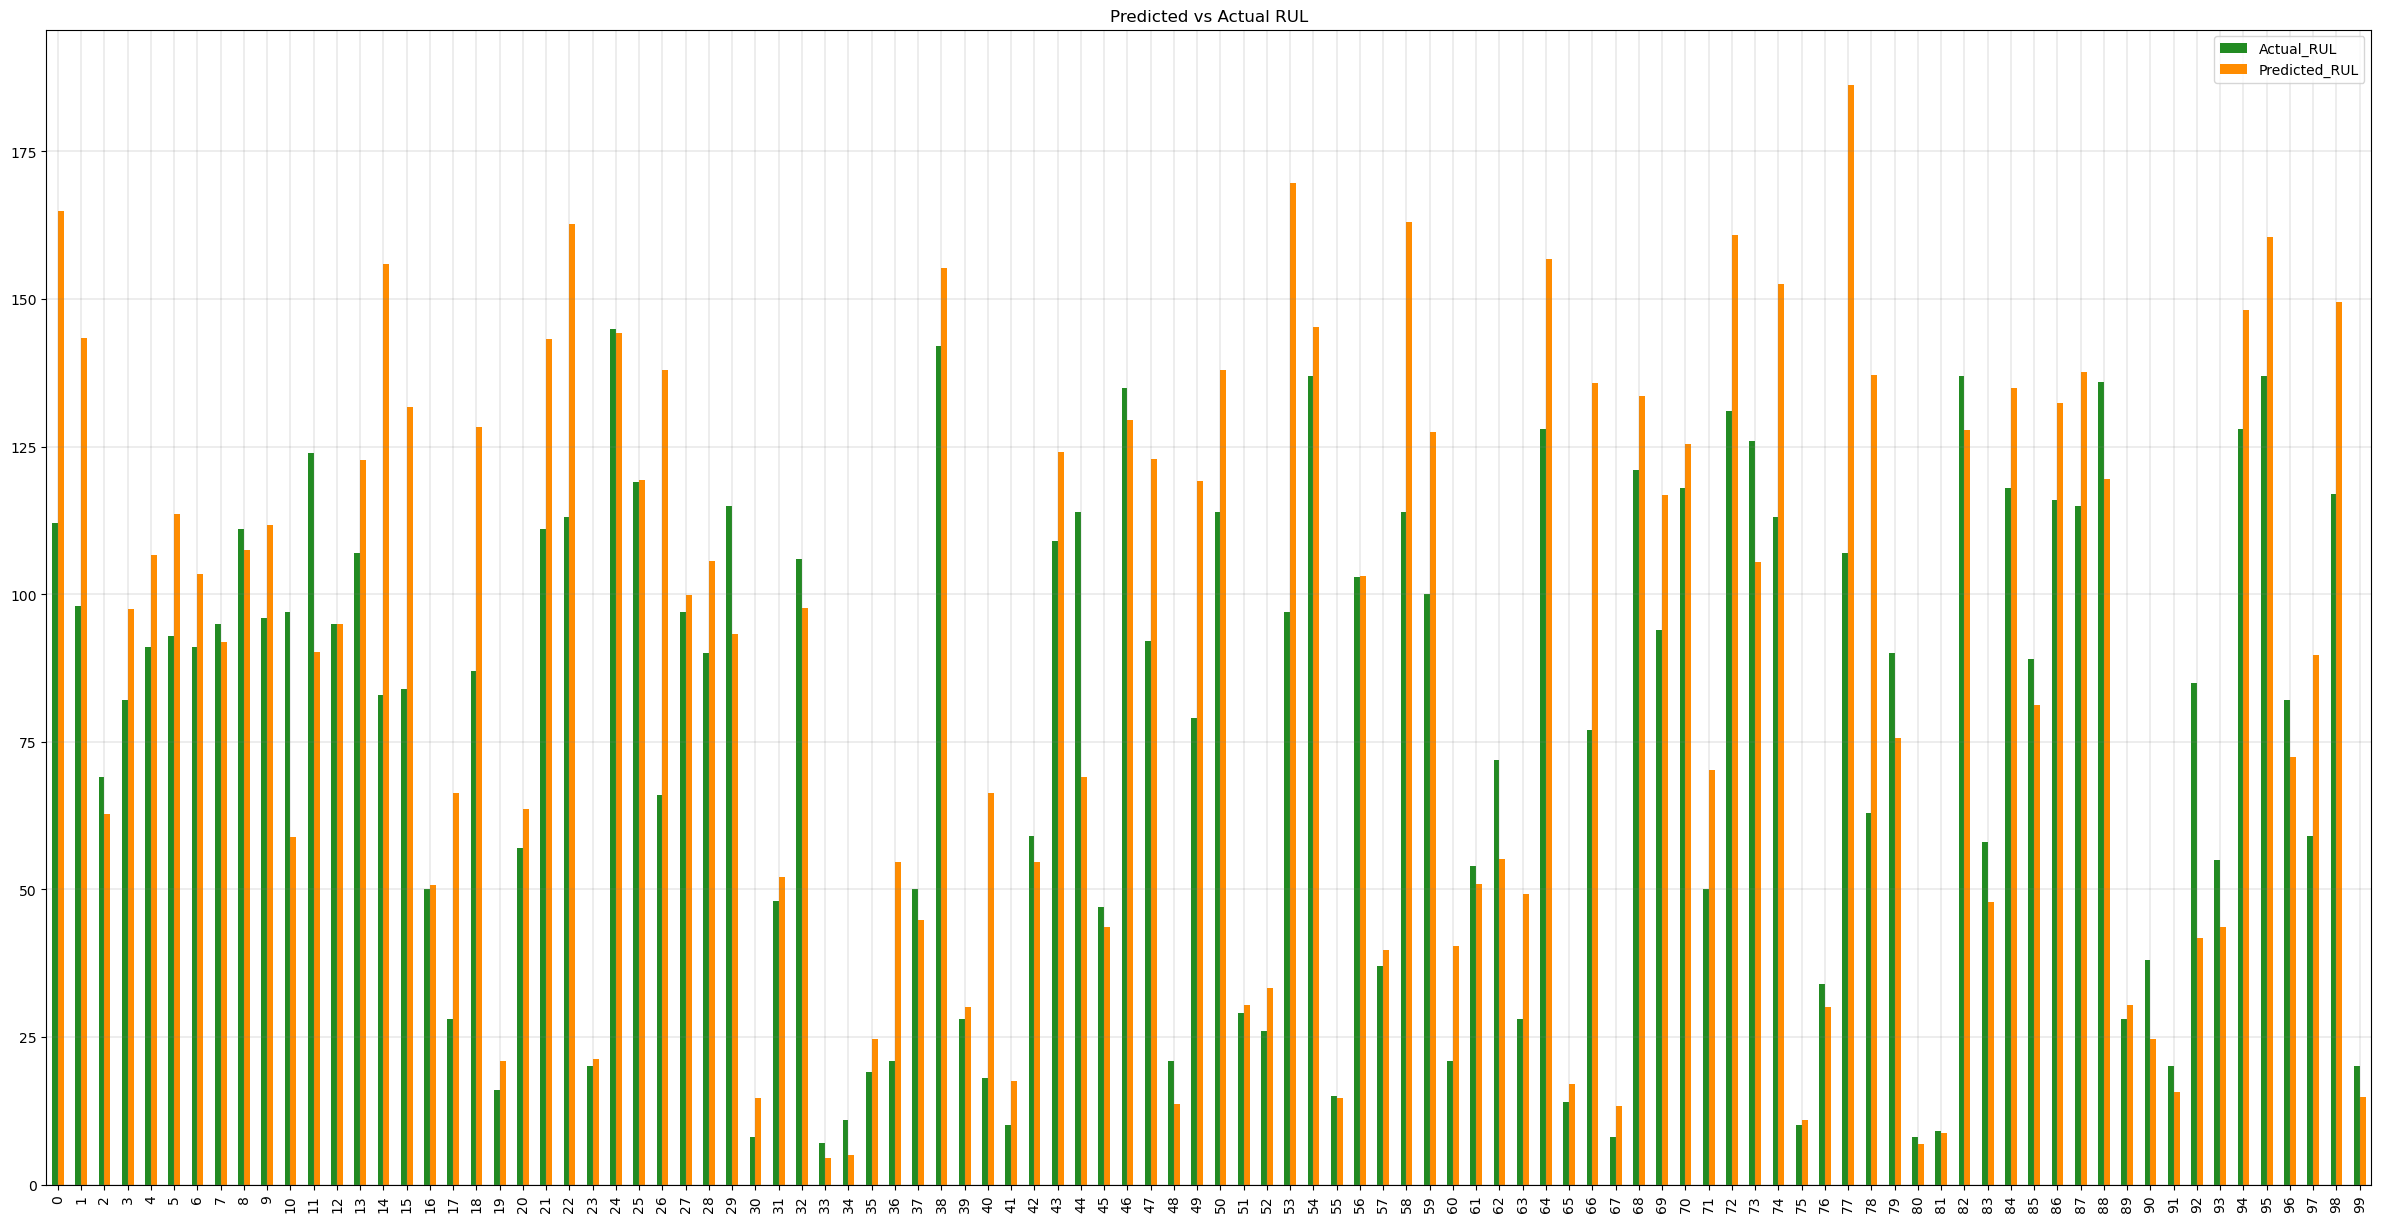

In [79]:
#compare actual RUL vs predicted RUL
# Explicitly defining a contrasting color palette
palette = {'Actual_RUL': 'forestgreen', 'Predicted_RUL': 'darkorange'}

predictions = combined_test_df.groupby('unit_number').last().reset_index()

predictions["Predicted_RUL"] =  y_pred
predictions["Actual_RUL"] =  y_valid

predictions['Diff'] = predictions["Predicted_RUL"] - predictions["Actual_RUL"]

predictions.sort_values(by="unit_number", inplace=True)

#plot
predictions.plot(kind='bar', y=["Actual_RUL","Predicted_RUL"],figsize=(30,15),color=palette)
plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.legend(loc='upper right',fontsize='medium')
plt.title("Predicted vs Actual RUL")
plt.show()

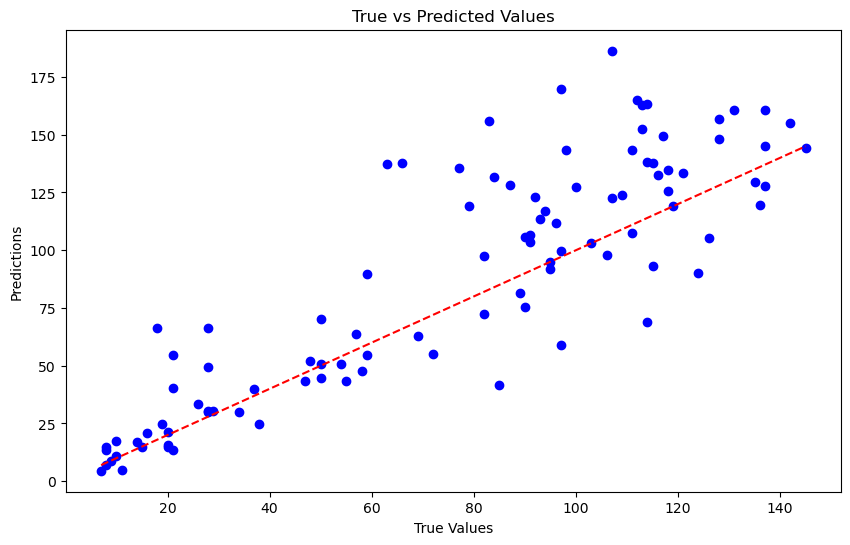

In [80]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, c='blue')
plt.plot([min(y_valid.to_numpy()), max(y_valid.to_numpy())], [min(y_valid.to_numpy()), 
                                                              max(y_valid.to_numpy())], '--', c='red')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

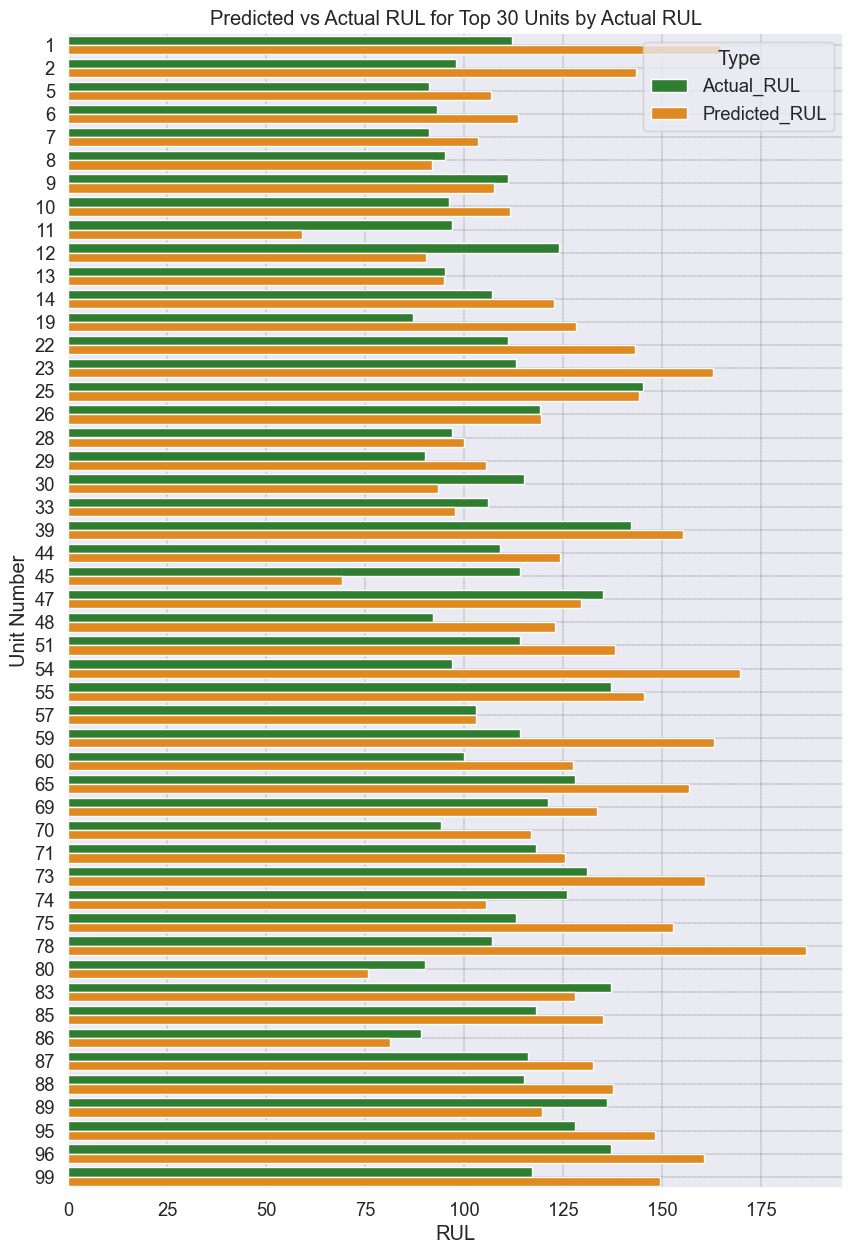

In [81]:
# Top 30 largest RULS
limited_predictions = predictions.nlargest(50, 'Actual_RUL')  

# Explicitly defining a contrasting color palette
palette = {'Actual_RUL': 'forestgreen', 'Predicted_RUL': 'darkorange'}

# Melt the DataFrame for Seaborn plotting
melted_predictions = limited_predictions.melt(id_vars=['unit_number'], 
                                              value_vars=['Actual_RUL', 'Predicted_RUL'], 
                                              var_name='Type', value_name='RUL')

plt.figure(figsize=(10, 15))  # Increase the size of the figure

sns.set(font_scale=1.2)  # Increase Font Size

sns.barplot(data=melted_predictions, y='unit_number', x='RUL', hue='Type', 
            palette=palette, orient='h')

plt.grid(True, linestyle='--', linewidth=0.2, color='black')
plt.legend(loc='upper right', title='Type')
plt.title("Predicted vs Actual RUL for Top 30 Units by Actual RUL")
plt.xlabel("RUL")
plt.ylabel("Unit Number")
plt.show()



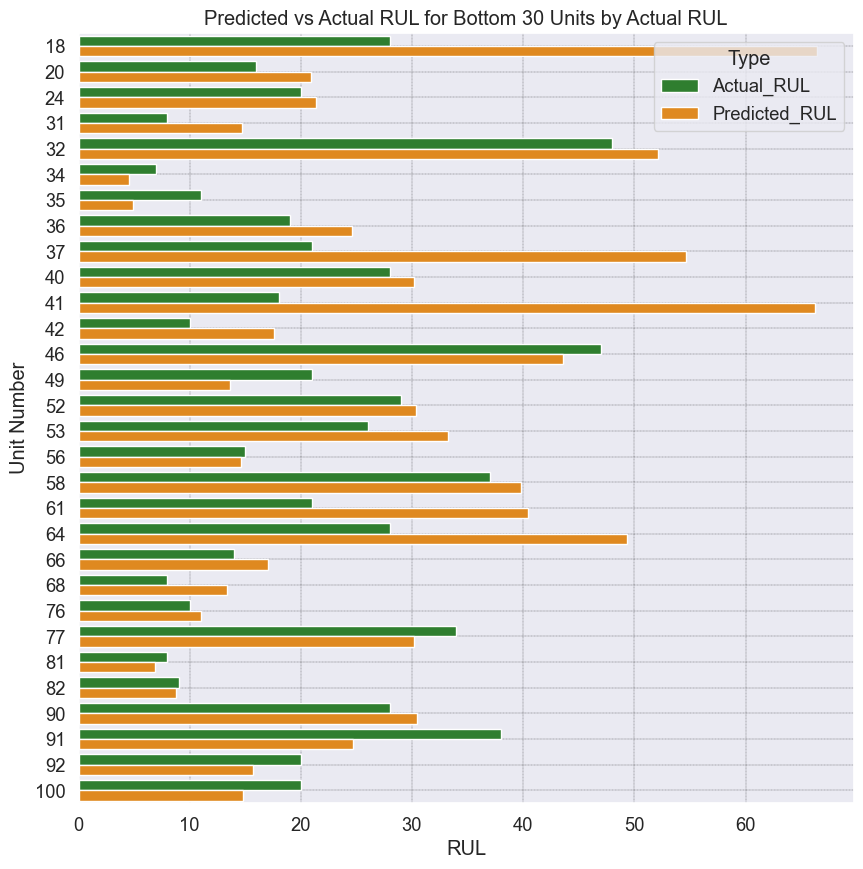

In [82]:
# Top 30 Smallest RULS
limited_predictions = predictions.nsmallest(30, 'Actual_RUL')  

# Explicitly defining a contrasting color palette
palette = {'Actual_RUL': 'forestgreen', 'Predicted_RUL': 'darkorange'}

# Melt the DataFrame for Seaborn plotting
melted_predictions = limited_predictions.melt(id_vars=['unit_number'], 
                                              value_vars=['Actual_RUL', 'Predicted_RUL'], 
                                              var_name='Type', value_name='RUL')

plt.figure(figsize=(10, 10))  # Increase the size of the figure

sns.set(font_scale=1.2)  # Increase Font Size

sns.barplot(data=melted_predictions, y='unit_number', x='RUL', hue='Type', 
            palette=palette, orient='h')

plt.grid(True, linestyle='--', linewidth=0.2, color='black')
plt.legend(loc='upper right', title='Type')
plt.title("Predicted vs Actual RUL for Bottom 30 Units by Actual RUL")
plt.xlabel("RUL")
plt.ylabel("Unit Number")
plt.show()



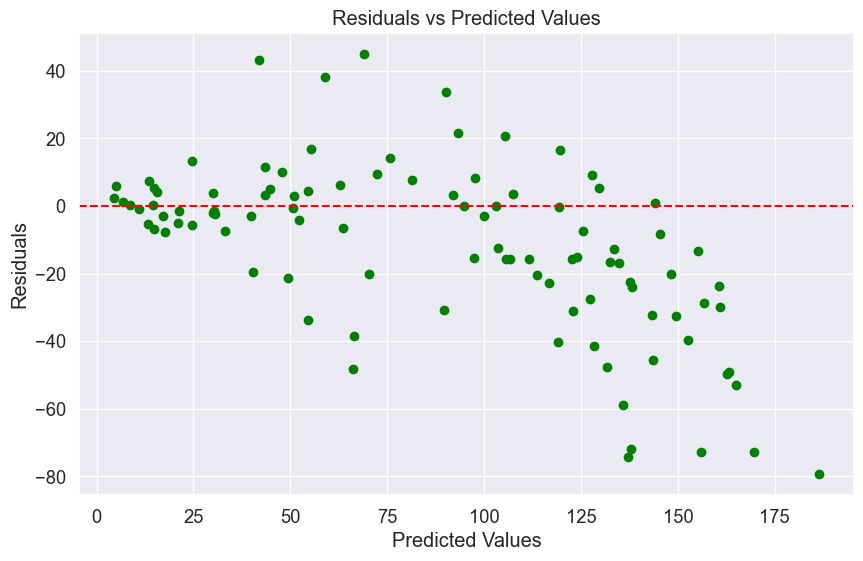

In [83]:
# Plot residuals
y_valid_array = np.squeeze(y_valid.to_numpy())
residuals = y_valid_array - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, c='green')
plt.axhline(y=0, linestyle='--', c='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

What we can interpret from these results is that our model does quite well when the RUL is lower but tends to be less accurate around predictions where actual RUL exceedes 60 cycles. <br><br> This is not bad considering that the most important and relevant predictions would be the ones where the RUL would be of a lower value (e.g. 10 or 20 cycles) indicating an immediate need for preventive maintenance. Since our model does quite well around these values, it could be useful in a real setting

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate the difference (residual) between actual and predicted RUL
residuals = y_valid_array - y_pred

# Create scatter plot with point size reflecting the Residual
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_valid_array, s=abs(residuals), c='green', alpha=0.5)
plt.axhline(y=0, linestyle='--', c='red')
plt.xlabel("Predicted RUL")
plt.ylabel("Actual RUL")
plt.title("Predicted vs Actual RUL with Residual Size")

# Calculate R-squared (R^2) for the entire dataset
r2 = r2_score(y_valid_array, y_pred)
print(f'R-squared (R^2) for the entire dataset: {r2:.2f}')

# Calculate Root Mean Squared Error (RMSE) for the entire dataset
rmse = np.sqrt(mean_squared_error(y_valid_array, y_pred))
print(f'RMSE for the entire dataset: {rmse:.2f}')

# Create subsets for RUL below and above 60
subset_below_60 = y_valid_array[y_valid_array < 60]
subset_pred_below_60 = y_pred[y_valid_array < 60]

subset_above_60 = y_valid_array[y_valid_array >= 60]
subset_pred_above_60 = y_pred[y_valid_array >= 60]

# Calculate R-squared (R^2) for RUL below 60
r2_below_60 = r2_score(subset_below_60, subset_pred_below_60)
print(f'R-squared (R^2) for RUL below 60: {r2_below_60:.2f}')

# Calculate RMSE for RUL below 60
rmse_below_60 = np.sqrt(mean_squared_error(subset_below_60, subset_pred_below_60))
print(f'RMSE for RUL below 60: {rmse_below_60:.2f}')

# Calculate R-squared (R^2) for RUL above or equal to 60
r2_above_60 = r2_score(subset_above_60, subset_pred_above_60)
print(f'R-squared (R^2) for RUL above or equal to 60: {r2_above_60:.2f}')

# Calculate RMSE for RUL above or equal to 60
rmse_above_60 = np.sqrt(mean_squared_error(subset_above_60, subset_pred_above_60))
print(f'RMSE for RUL above or equal to 60: {rmse_above_60:.2f}')

mae_above_60 = mean_absolute_error(subset_above_60, subset_pred_above_60)
print(f'MAE for RUL above or equal to 60: {mae_above_60:.2f}')


plt.show()